# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

In [2]:
def read_transformations(filename='poses.txt'):
    f = open(filename, 'r')
    data = np.loadtxt(filename)
    N = len(data)
    transformation_list = data.reshape(N,3,4);
    return N, transformation_list

# K
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
             [0.000000e+00, 7.070912e+02, 1.831104e+02],
             [0.000000e+00, 0.000000e+00, 1.000000e+00]])

# baseline
b = 0.53790448812

# f
f = K[0,0]

N, T = read_transformations('poses.txt')

## Explanation: 

- We have projection matrix for transforming 2D points to 3D points and we have images from left camera and right camera, so we use stereo vision. 
- So as we have the image of a specific point from two different camera, we can find the actual location of that point in World frame.
- We have pair of images and so as we know that the shift on the location of that point with respect to left camera on right camera is disparity. ( Disparity refers to the difference in the location of an object in corresponding two (left and right) images as seen by the left and right eye (or camera) which is created due to parallax (eyes’ horizontal separation))

- So firstly we calculate disparity of every stereo pair and store that in a matrix called disparity, this is done by a cv2 function ` steroSGBM_create()` - this function uses an algorithm for matching blocks, and not individual pixels which increase the accuracy and the speed of our algo to calculate disparity

- Now we have to find the point cloud and for that firstly we need to find Q matrix, The Q matrix describes how the depth map is transformed into the 3D coordinate space. The constrction of the Q matrix is present in the function `Q_arr` given below

- We have with us, point_cloud_i = $(x,y,disparity(x,y),1)^{T}$ - for the ith observation, this multiplied with Q gives us the point cloud.

- The point cloud of images can be obtained as
$$Z = (b*f)/(x_1-x_2)$$
$$X = (Z*x)/f$$
$$Y = (Z*y)/f$$
$$\text{Here, }$$
$$b = \text{baseline}$$
$$f = \text{focal length}$$
$$x_1 \text{ is point in left image and } x_2 \text{ is corresponding point in right image}$$
$$ x = (x_1+x_2)/2$$
$$ y = (y_1+y_2)/2$$
- As we have to combine the mutliple point clouds, we multiply the every point_cloud of every stereo pair with the corresponding projection matrix(which is already given to us) to get all the final_points in the world frame.

- After that we use mask to remove redundant points(noise), using the mask we are able to remove maximum number of redundant points(not all),so from that we will get our final point cloud which we will plot using open3d and use this point cloud in the next question to recover R and t.

In [3]:
pcd = o3d.geometry.PointCloud()
combined_pcd = o3d.geometry.PointCloud()

def toWorldframe(points,wTc):
    points = (wTc@points.T).T
    return points

def imageToWorld(disparity_map,Q):
    points = []
    for m in disparity_map:
        point = Q@m
        points.append(point)
    return np.array(points)


def find_parallax(disparity):
    disparity_map = [];
    h,w = disparity.shape
    for i in range(h):
        for j in range(w):
            disparity_map.append([j,i,disparity[i,j],1])
    return np.array(disparity_map)


def find_disparity(left,right):
    window_size = 5 ; num_disp=144 ; min_disp=-39
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp, numDisparities = num_disp,
                                   blockSize = 5,
                                   P1 = 8 * 3 * window_size ** 2,P2 = 64 * 3 * window_size ** 2,
                                   disp12MaxDiff = 1,
                                   uniquenessRatio = 10,
                                   speckleWindowSize = 100,
                                   speckleRange = 32,
                                   preFilterCap = 63)
    disparity = stereo.compute(left, right).astype(np.float32)/64.0
    disparity = (disparity-min_disp)/num_disp
    return disparity


for i in range(N):    
    t = 60+i
    img2 = "./img2/00000004"+str(t)+".png"
    img3 = "./img3/00000004"+str(t)+".png"
    left_image = cv2.imread(img2)
    right_image = cv2.imread(img3)
    disparity = find_disparity(left_image,right_image)

    h,w = disparity.shape
    Q = np.array([[ 1,   0,  0,-w/2],
                  [ 0,  -1,  0, h/2],
                  [ 0,   0,  0,   f],
                  [ 0,   0,  1/b, 0]])
    
    disparity_map = find_parallax(disparity)
    pcd_points = imageToWorld(disparity_map,Q)
    colors = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
    mask = (disparity >= disparity.min())
    colors = colors[mask]
    colors = colors/255
    pcd_colors = np.array(colors);
    pcd_points = (pcd_points.T/(pcd_points.T[3])).T
    
    pcd_points = toWorldframe(pcd_points,T[i]);

    mask = (-1500<=pcd_points) * (pcd_points<=1500)
    mask = np.all(mask,axis=1)
    
    pcd_points = pcd_points[mask]
    pcd_colors = pcd_colors[mask]
    pcd_points[:,0] *= -1
    pcd.points = o3d.utility.Vector3dVector(pcd_points)
    pcd.colors = o3d.utility.Vector3dVector(pcd_colors)
    combined_pcd = combined_pcd + pcd
    print(str(i+1)+" Left and right images are combined and converted into world frame PCD")
    
#Saving the combined pcd 
o3d.io.write_point_cloud("Output.pcd", combined_pcd)

1 Left and right images are combined and converted into world frame PCD
2 Left and right images are combined and converted into world frame PCD
3 Left and right images are combined and converted into world frame PCD
4 Left and right images are combined and converted into world frame PCD
5 Left and right images are combined and converted into world frame PCD
6 Left and right images are combined and converted into world frame PCD
7 Left and right images are combined and converted into world frame PCD
8 Left and right images are combined and converted into world frame PCD
9 Left and right images are combined and converted into world frame PCD
10 Left and right images are combined and converted into world frame PCD
11 Left and right images are combined and converted into world frame PCD
12 Left and right images are combined and converted into world frame PCD
13 Left and right images are combined and converted into world frame PCD
14 Left and right images are combined and converted into wor

True

In [4]:
#Reading and visualising the saved PCD
def read_visualise(pcd_name):
    output = o3d.io.read_point_cloud(pcd_name)
    o3d.visualization.draw_geometries([output])
    return

read_visualise("Output.pcd")

### Combined Point Cloud of World points using all images 
![Output_pcd.jpeg](./Output_pcd.jpeg)

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [5]:
def read_pcd(file_name):
    #Read the point cloud
    pcd = o3d.io.read_point_cloud(file_name) 
    points = np.asarray(pcd.points).astype(np.float32)
    pcd_points = np.hstack((points,np.ones((len(points),1))))
    return pcd_points

def DLT(x_gt,X_gt):
    x = np.copy(x_gt[:10]);
    X = np.copy(X_gt[:10])
    x[:,0] = x[:,0]/x[:,2];
    x[:,1] = x[:,1]/x[:,2];
    L = len(X);
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    Ax = np.hstack((-X,np.hstack((zeros,A))));
    Ay = np.hstack((zeros,np.hstack((-X,B))));    
    M = np.vstack((Ax,Ay))
    U,D,VT = np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    P = P/P[-1,-1]
    return P


def residual(x,x_gt):
    A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
    B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
    res = (np.hstack((A,B))).reshape(-1,1)
    return res


def Jacobian(x,X):
    L = len(X);
    X[:,0] = X[:,0]/x[:,2]
    X[:,1] = X[:,1]/x[:,2]
    X[:,2] = X[:,2]/x[:,2]
    X[:,3] = X[:,3]/x[:,2]
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    J_x = np.hstack((-X,np.hstack((zeros,A))));
    J_y = np.hstack((zeros,np.hstack((-X,B))));
    J = np.vstack((J_x,J_y))
    return J


def Gauss_newton(P,x_gt,X,N,tol): 
    Cost = np.zeros(N)
    for i in range(N):
        x = (P@X.T).T
        res = residual(x,x_gt) 
        Cost[i] = (res.T@res/2/len(X)).item(0);
        if(i==0):
            print("\nInitial Cost (in terms of MSE) = ",Cost[0])
        J = Jacobian(np.copy(x),np.copy(X));
        H = J.T@J;
        update = np.linalg.inv(H)@J.T@res;
        P = (P.reshape(12,1) - update).reshape(3,4);
        if(np.linalg.norm(update)<tol):
            print("\nGN has converged")
            break;
    return P, Cost, i

# 1. Initialisation using DLT of first 10 points

P_GT = 
[[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

T_GT = 
[[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

Initialisation using P_DLT = 
[[ 3.20616307e+01 -1.93747971e+00  9.21655658e+00  5.50896926e+03]
 [ 1.32490523e+00 -2.56734768e+01  5.48021083e+00 -7.19745270e-01]
 [ 1.48027108e-02 -1.47811959e-03  3.27679562e-02  1.00000000e+00]]

Initial Cost (in terms of MSE) =  9890.31009126612

GN has converged

Final Cost (in terms of MSE) =  2.1154068526679046e-13

iterations to converge =  8

P_Output = 
[[-8.90929515e+02  5.38387636e+01 -2.56109929e+02 -1.53083395e+05]
 [-3.68165069e+01  7.13415332e+02 -1.52284248e+02  2.00005412e+01]
 [-4.11338164e-01  4.10740947e-02 -9.1055689

Text(0, 0.5, 'Cost (in terms of MSE)')

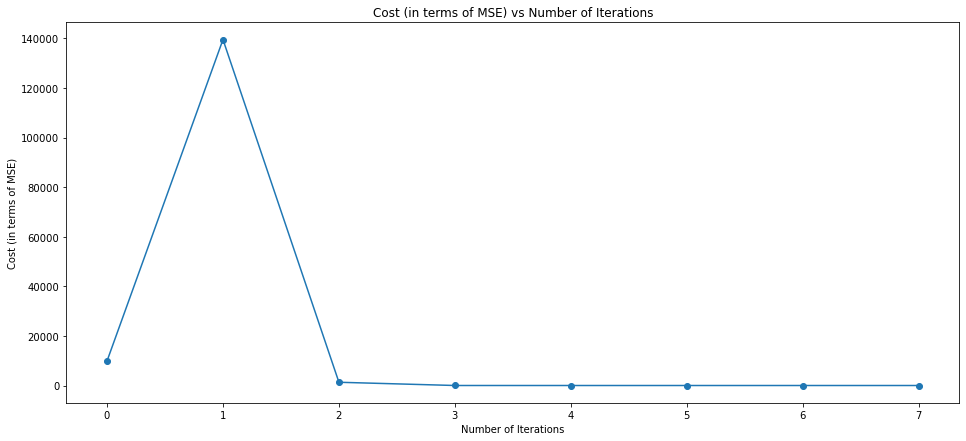

In [6]:
#Initialising using DLT of 10 points
X_gt = read_pcd("Output.pcd")
X_gt = X_gt[0:-1:10]
T_gt = np.eye(4,4)
T_gt[:3,:4] = T[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K@T_gt[:3,:4]
x_gt = (P_gt@X_gt.T).T

P_dlt = DLT(x_gt,X_gt)

print("P_GT = ")
print(P_gt)
print("\nT_GT = ")
print(np.linalg.inv(K)@P_gt)

print("\nInitialisation using P_DLT = ")
print(P_dlt)

P_op, Cost, it_conv = Gauss_newton(P_dlt,np.copy(x_gt),np.copy(X_gt),1000,1e-5)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 

print("\nFinal Cost (in terms of MSE) = ",Cost[it_conv])
print("\niterations to converge = ",it_conv+1)
print("\nP_Output = ")
print(P_op)
print("\nT_Output = ")
print(np.linalg.inv(K)@P_op)

plt.figure(figsize=(16,7));
plt.plot(range(it_conv+1), Cost[0:it_conv+1],'o-');
plt.title('Cost (in terms of MSE) vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (in terms of MSE)')

# 2. Initialisation using Identity Transform

P_GT = 
[[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

T_GT = 
[[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

Initialisation using random T = 
[[7.0709120e+02 0.0000000e+00 6.0188730e+02 1.3089785e+03]
 [0.0000000e+00 7.0709120e+02 1.8311040e+02 8.9020160e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]]

Initial Cost (in terms of MSE) =  437912882.7650787

Final Cost (in terms of MSE) =  438196809.9122707

iterations to converge =  1000

P_Output = 
[[ 9.24976023e-02  3.45964643e-01  7.43789033e-01  6.44111881e+02]
 [-5.95383000e-01 -2.19639326e+00 -4.84051503e+00 -4.20681969e+03]
 [-3.93312361e-03 -1.45021534e-02 -3.19740568e-02 -2.77880277e+01]]

T_Output = 
[[ 

Text(0, 0.5, 'Cost (in terms of MSE)')

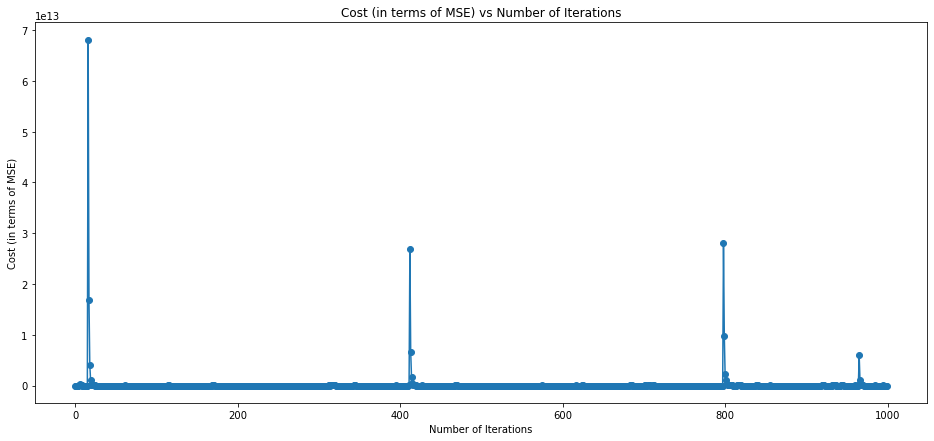

In [7]:
#Initialising using Identity Transform

X_gt = read_pcd("Output.pcd")
X_gt = X_gt[0:-1:100]
T_gt = np.eye(4,4)
T_gt[:3,:4] = T[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K@T_gt[:3,:4]
x_gt = (P_gt@X_gt.T).T

P_id = K@np.hstack((np.eye(3),np.ones((3,1)))) 

print("P_GT = ")
print(P_gt)
print("\nT_GT = ")
print(np.linalg.inv(K)@P_gt)

print("\nInitialisation using random T = ")
print(P_id)

P_op, Cost, it_conv = Gauss_newton(P_id,x_gt,X_gt,1000,1e-5)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 

print("\nFinal Cost (in terms of MSE) = ",Cost[it_conv])
print("\niterations to converge = ",it_conv+1)
print("\nP_Output = ")
print(P_op)
print("\nT_Output = ")
print(np.linalg.inv(K)@P_op)

plt.figure(figsize=(16,7));
plt.plot(range(it_conv+1), Cost[0:it_conv+1],'o-');
plt.title('Cost (in terms of MSE) vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (in terms of MSE)')


# 3. Initialising using Random Transform

P_GT = 
[[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

T_GT = 
[[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

Initialisation using random T = 
[[4.54588592e+02 9.31761734e+02 4.23668477e+02 2.40005474e+02]
 [5.21733324e+02 8.21997681e+02 5.20292375e+01 4.33782334e+02]
 [2.79984547e-01 7.97609825e-01 1.65084444e-01 2.66699388e-01]]

Initial Cost (in terms of MSE) =  115479788349.72798

Final Cost (in terms of MSE) =  437925173.9721019

iterations to converge =  1000

P_Output = 
[[ 3.43340168e+03  9.76189477e+03  2.03701303e+03  2.44074657e+04]
 [-1.64917095e+03 -4.68488873e+03 -9.70814220e+02 -3.33300583e+03]
 [-7.93613116e+00 -2.25500042e+01 -4.68263440e+00 -2.77880277e+01]]

T_

Text(0, 0.5, 'Cost (in terms of MSE)')

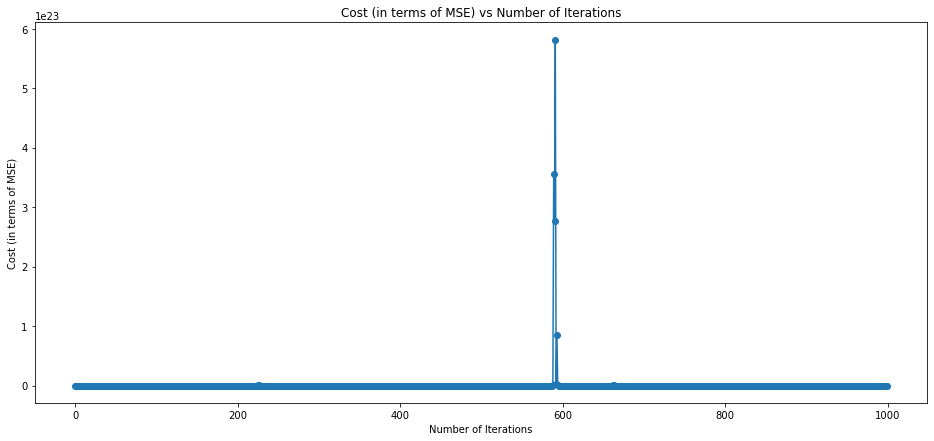

In [8]:
#Initialising using Random Transform

X_gt = read_pcd("Output.pcd")
X_gt = X_gt[0:-1:100]
T_gt = np.eye(4,4)
T_gt[:3,:4] = T[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K@T_gt[:3,:4]
x_gt = (P_gt@X_gt.T).T

P_rand = K@np.random.rand(3,4) 

print("P_GT = ")
print(P_gt)
print("\nT_GT = ")
print(np.linalg.inv(K)@P_gt)

print("\nInitialisation using random T = ")
print(P_rand)

P_op, Cost, it_conv = Gauss_newton(P_rand,x_gt,X_gt,1000,1e-5)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 

print("\nFinal Cost (in terms of MSE) = ",Cost[it_conv])
print("\niterations to converge = ",it_conv+1)
print("\nP_Output = ")
print(P_op)
print("\nT_Output = ")
print(np.linalg.inv(K)@P_op)

plt.figure(figsize=(16,7));
plt.plot(range(it_conv+1), Cost[0:it_conv+1],'o-');
plt.title('Cost (in terms of MSE) vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (in terms of MSE)')

## Conclusion

- DLT output as initialization gives us best results that converges faster.
- If the initialization is close to a local maxima, the algorithm will converge to that minima and thus not obtain the optimal configuration.
- A bad initialization may lead to no solution for example random initialisation.
- Thus Iterative PnP is useful to recover the poses given the 3D-2D correspondences.

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: `We can label the image points with the appropriate camera index at the time of capturing the image in any particular camera frame. Thus while recovering an image point we need to just look for a particular time stamp and the camera index.`
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: `We can initialise the 3D points using something like triangulation. To initialise the 3D points, we use the essential matrix, corresponding points and the camera matrix to traingulate the initial 3D points. We can easily store which image points correspond to which 3D point and hence assign the indices accordingly.`
    
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations: `The translation vector is in for example C_1 frame, hence we cannot add it to the image point vector which is in say some C_2 frame. We can only add the translation vector when the image point vector is rotated so that it is represented in the same orientation as of C_1 frame.`
    
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: `In lecture notes we assumed that every 3D point was captured in all the different images. So, number of residuals were 2*n*m where n is number of world points and m is number of camera poses. Practically, this assumption will not be satisfied. So here, no of residuals are 2*(total observations) where total observations are not equal to m*n.`

5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters: `The camera projection matrix is P = K[R | t] of size 3x4. In the class for the sake of simplicity we considered all 12 variables of P matrix to be independent. But in reality R has only 3 independent variables i.e. 3 euler angles or 3 independent variables as the axis of rotation in axis angle notation, t has 3 independent varibles as coordinates and then K has 3 independent variables i.e the focal length and 2 distortion parameters. Thus, P has actually 9 independent parameters in total. That is why we are using n_cameras * 9.`
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters: `In the lecture notes, it is 12*n_cameras + 3*n_points, n_points = (n_images x n_points_per_image)/n_times_every_point_is_seen). In the code, it is 9*n_cameras + 3*n_points. The reason for this difference is the same as explained in previous question i.e. P only has 9 independent parameters, but in the lecture we assumed that P has 12 independent parameters. Also, there is no need to calculate n_points as in the lecture notes due to fact that we are already provided with it.`
        
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: ` The above 6 lines of code fills populates a sparse jacobian in which we specify certain locations to have 1s and 0s. In the below code, in the theoretical setting, The space jacobian has a neat structure. However, that is not the case in practical settings. In the practical setting, we decide to set a value at an index to 1 depending on the dependant variables which are to be optimized (for eg, the camera parameters and the 3D points). Thus, the places where 1 is present will not be as structured as the previous case. Sparsifying the jacobian will also speed up the run time of the code because it allows Scipy solver to take advantage of the Sparsity. In our Jacobian matrix, every row corresponds to a residual, every column is a parameter being optimized. There are `9* No of cameras` + `3* No. of world_points` params, and hence columns. Each 2D point has 2 coordinates, (x and y) so there are twice as many residuals as no. of observations. For N points observed in M images, we had MN rows for the examples done in class, but here, we have `camera_ind.size` observations and twice as many rows.` 

In [9]:
# NOTE: for a practical scenerio, no_of_observations will not be n_camera*n_points, but its to make 
#better comparison
np.random.seed(3)
def sparsity_matrix(n_cameras, n_points, n_observations, practical=True):

    if practical:
        camera_indices = np.random.randint(n_cameras, size=n_observations)
        point_indices = np.random.randint(n_points, size=n_observations)
    else:
        camera_indices = np.zeros(n_observations, dtype=int)
        point_indices = np.zeros(n_observations, dtype=int)
        
        for i in range(n_cameras):
            for j in range(n_points):
                camera_indices[5*i + j] = i
                point_indices[5*i + j] = j

    print("camera_indices:\n{}\n".format(camera_indices))
    print("point_indices:\n{}\n".format(point_indices))

    m = len(camera_indices) * 2 

    n = n_cameras * 9 + n_points * 3 

    J = np.zeros((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        J[2 * i, camera_indices * 9 + s] = 1
        J[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        J[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        J[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return J


print("\nTheoratical:\n")
print("Jacobian sparsity matrix:\n{}\n".format(sparsity_matrix(2, 5, 2*5, practical=False)))

print("\nPractical:\n")
print("Jacobian sparsity matrix:\n{}\n".format(sparsity_matrix(2, 5, 2*5, practical=True)))


Theoratical:

camera_indices:
[0 0 0 0 0 1 1 1 1 1]

point_indices:
[0 1 2 3 4 0 1 2 3 4]

Jacobian sparsity matrix:
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**
1. First we need to do feature matching. For this, we use ORB detector class of openCV i.e. `cv2.ORB_create()` and use its `detectAndCompute()` function as a detector to extract ORB features (keypoints, descriptors) on both images. We pass `None` to show that we are not passing predefines features.
    - `orb = cv2.ORB_create()`
    - `kp1, des1 = orb.detectAndCompute(img1,None)`
    - `kp2, des2 = orb.detectAndCompute(img2,None)`
   So, now we have keypoints and descriptors corresponding to img1 and img2.
   
2. Now, we need to match keypoints from the two images. For this, create a Brute-Force Matcher `bf = cv2.BFMatcher()`, and using the `matches = matcher.match(img1Descriptors,img2Descriptors)` function, 
    - `bf = cv2.BFMatcher()`
    - `matches = bf.match(des1,des2)`
    - Now we have matched features from both images. We can then use these "matches" to obtain the corresponding points in two images. We will store this as p_0 and p_1.
    
3. In order to obtain the Essential matrix `E`, we use `cv2.findEssentialMat()` function with corresponding points i.e p_0, p_1 and K matrix as input
    - `E = cv2.findEssentialMat(p_0,p_1,K)`
    
4. We have essential matrix, we can decompose it into R,t using `cv2.recoverPose()` that takes Essential matrix `E`, K matrix and the corresponding points in two images as input arguments and gives us `R,t`:
    - `Rt = cv2.recoverPose(E, p_0, p_1, K)`
    - `R = Rt[1]`
    - `t = Rt[2]`

5. Now we will use triangulation to initialize the 3D poses. We will use the `cv2.triangulatePoints()` function as follows that takes corresponding points in two images as input along with Rt and gives points in world frame as output:
    - `points_3d = cv2.triangulatePoints([p_0,p_1],Rt)`
